In [12]:
import numpy as np
import scipy
import trackhhl.toy.simple_generator as toy
import trackhhl.hamiltonians.simple_hamiltonian as hamiltonian

N_MODULES = 3
#test bounds of LX and LY
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX]*N_MODULES,
    ly=[LY]*N_MODULES,
    z=[i+Z_SPACING for i in range(N_MODULES)])

generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi/6)

N_PARTICLES = 2

event = generator.generate_event(N_PARTICLES) # [0]
# print(event)
ham = hamiltonian.SimpleHamiltonian(epsilon=1e-3,gamma=2.0,delta=1.0)

ham.construct_hamiltonian(event=event)

a_matrix = ham.A.todense()

b_vector = ham.b

transpilation_options = {"classiq": "auto optimize", "qiskit": 1}

sol_classical = np.linalg.solve(a_matrix, b_vector)  # classical solution
print(sol_classical)

# number of qubits for the unitary
num_qubits = int(np.log2(len(b_vector)))
# exact unitary
my_unitary = scipy.linalg.expm(1j * 1 * np.pi * a_matrix)

a_matrix

[0.5        0.33333333 0.33333333 0.5        0.5        0.33333333
 0.33333333 0.5       ]


matrix([[ 3.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  3.,  0.,  0.,  0., -1.],
        [-1.,  0.,  0.,  0.,  3.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.],
        [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  3.]])

In [13]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit.circuit import QuantumCircuit
from qiskit import transpile


def power1(self, opt = None) -> "QuantumCircuit":

        pauli_op = SparsePauliOp.from_operator(a_matrix).simplify()
        gate = PauliEvolutionGate(pauli_op)
        st = SuzukiTrotter(order = 2, reps = 1)
        #st = QDrift(reps = 1)
        #st = LieTrotter(reps=4)
        #st = MatrixExponential()
        gate.time = 1 * np.pi
        trotter_circuit = st.synthesize(gate)
        trotter_circuit = transpile(trotter_circuit, optimization_level=3)
        return trotter_circuit

QuantumCircuit.power1 = power1

In [16]:
import qiskit as q

In [17]:
q.circuit.library.data_preparation.

<module 'qiskit.circuit.library' from '/Users/georgescriven/anaconda3/envs/Q_env/lib/python3.10/site-packages/qiskit/circuit/library/__init__.py'>

In [15]:
from qiskit.circuit.library import Isometry, Initialize

ImportError: cannot import name 'Isometry' from 'qiskit.circuit.library' (/Users/georgescriven/anaconda3/envs/Q_env/lib/python3.10/site-packages/qiskit/circuit/library/__init__.py)

In [14]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import PhaseEstimation as PhaseEstimation_QISKIT
from qiskit.circuit.library.arithmetic.exact_reciprocal import ExactReciprocal
from qiskit.circuit.library import Isometry, Initialize

def get_qiskit_hhl_results(precision, ham):
    """
    This function creates an HHL circuit with qiskit, execute it and returns the depth, cx-counts and fidelity
    """

    vector_circuit = QuantumCircuit(num_qubits)
    initi_vec = Initialize(b_vector / np.linalg.norm(b_vector))

    vector_circuit.append(
        initi_vec, list(range(num_qubits))
    )

    q = QuantumRegister(num_qubits, "q")
    unitary_qc = QuantumCircuit(q)
    unitary_qc.unitary(my_unitary.tolist(), q)
    unitary_qc.power1(opt = unitary_qc)

    qpe_qc = PhaseEstimation_QISKIT(precision, unitary_qc)
    reciprocal_circuit = ExactReciprocal(
        num_state_qubits=precision, scaling=1 / 2**precision)

    # Initialise the quantum registers
    qb = QuantumRegister(num_qubits)  # right hand side and solution
    ql = QuantumRegister(precision)  # eigenvalue evaluation qubits
    qf = QuantumRegister(1)  # flag qubits

    hhl_qc = QuantumCircuit(qb, ql, qf)

    # State preparation
    hhl_qc.append(vector_circuit, qb[:])
    # QPE
    hhl_qc.append(qpe_qc, ql[:] + qb[:])
    # Conditioned rotation
    hhl_qc.append(reciprocal_circuit, ql[::-1] + [qf[0]])

    # QPE inverse
    hhl_qc.append(qpe_qc.inverse(), ql[:] + qb[:])

    # transpile
    tqc = transpile(
        hhl_qc,
        basis_gates=["u3", "cx"],
        optimization_level=transpilation_options["qiskit"],
    )
    depth = tqc.depth()
    cx_counts = tqc.count_ops()["cx"]
    total_q = tqc.width()

    # execute
    statevector = np.array(Statevector(tqc))

    # post_process
    all_entries = [np.binary_repr(k, total_q) for k in range(2**total_q)]
    sol_indices = [
        int(entry, 2)
        for entry in all_entries
        if entry[0] == "1" and entry[1 : precision + 1] == "0" * precision
    ]
    qsol = statevector[sol_indices] / (1 / 2**precision)

    sol_classical = np.linalg.solve(a_matrix, b_vector)
    fidelity = (
        np.abs(
            np.dot(
                sol_classical / np.linalg.norm(sol_classical),
                qsol / np.linalg.norm(qsol),
            )
        )
        ** 2
    )
    print(qsol)
    print(qsol*(1/max(qsol)))
    #print(sol_classical / np.linalg.norm(sol_classical))
    #print(np.where(sol_classical < 0.45, 0, sol_classical))

    state_vector = Statevector.from_instruction(tqc)
    solution_norm = np.linalg.norm(state_vector.data)
    post_select_qubit = int(np.log2(len(state_vector.data))) - 1
    solution_len = len(ham.b)
    base = 1 << post_select_qubit
    solution_vector = state_vector.data[base : base + solution_len].real

    # Renormalize the solution vector
    solution_vector = (
        solution_vector
        / np.linalg.norm(solution_vector)
        * solution_norm
        * np.linalg.norm(ham.b)
    )
    return total_q, depth, cx_counts, fidelity, qsol, solution_vector

ImportError: cannot import name 'Isometry' from 'qiskit.circuit.library' (/Users/georgescriven/anaconda3/envs/Q_env/lib/python3.10/site-packages/qiskit/circuit/library/__init__.py)

In [ ]:
qiskit_widths = []
qiskit_depths = []
qiskit_cx_counts = []
qiskit_fidelities = []

#total_q, depth, cx_counts, fidelity = get_qiskit_hhl_results(8, ham)

for per in range(5,6):
    total_q, depth, cx_counts, fidelity, qsol, solution_vector = get_qiskit_hhl_results(per, ham)
    qiskit_widths.append(total_q)
    qiskit_depths.append(depth)
    qiskit_cx_counts.append(cx_counts)
    qiskit_fidelities.append(fidelity)
    print(qiskit_depths)
    print(fidelity)


[-7.39235668e-16+2.84511791e-30j -3.01870138e-16+1.08297357e-30j]
[2.44885325-6.39594759e-16j 1.        +9.52816739e-32j]
[144]
0.8499920628594555


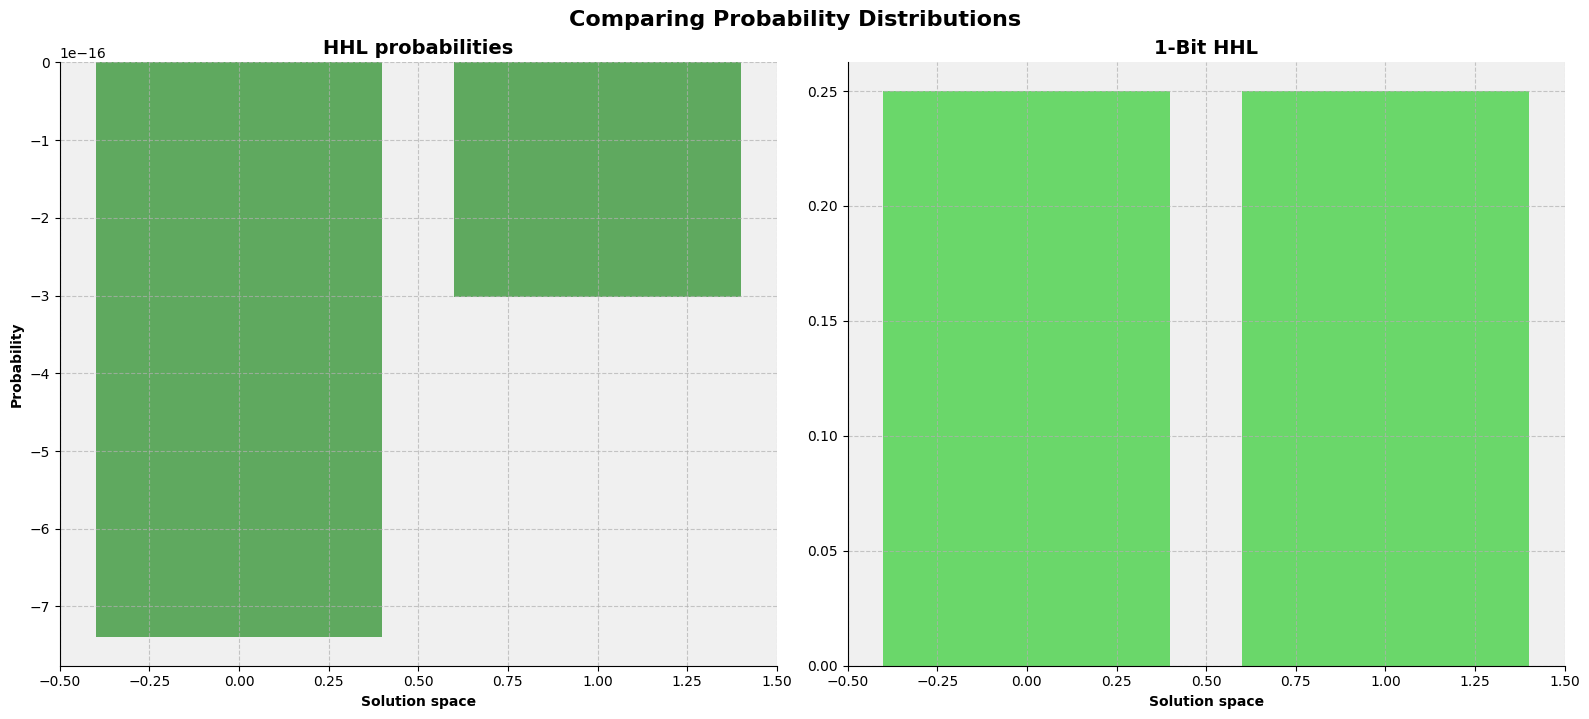

In [ ]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


import matplotlib.pyplot as plt
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16, 7))

# Common styling
for ax in (ax1, ax2):
    ax.set_facecolor('#f0f0f0')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Original data plots
ax1.bar(np.arange(len(qsol)), qsol, color="forestgreen", alpha=0.7)
ax1.set_xlim(-0.5, len(qsol) - 0.5)
ax1.set_xlabel("Solution space", fontweight='bold')
ax1.set_ylabel("Probability", fontweight='bold')
ax1.set_title("HHL probabilities", fontsize=14, fontweight='bold')

normalized_classical = normalize_data(solution_vector)
ax2.bar(np.arange(len(solution_vector)), sol_classical/np.count_nonzero(sol_classical), color="limegreen", alpha=0.7)
ax2.set_xlim(-0.5, len(solution_vector) - 0.5)
ax2.set_xlabel("Solution space", fontweight='bold')
ax2.set_title("1-Bit HHL", fontsize=14, fontweight='bold')

# Normalized data plots


plt.tight_layout()
fig.suptitle("Comparing Probability Distributions", fontsize=16, fontweight='bold', y=1.02)
plt.show()

### Testing Original


In [ ]:
a_matrix = np.array(
    [
        [ 3.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  3.,  0.,  0.,  0., -1.],
        [-1.,  0.,  0.,  0.,  3.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.],
        [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  3.]
    ]
)

b_vector = np.array(
    [
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
    ]
)

sol_classical = np.linalg.solve(a_matrix, b_vector)  # classical solution

# number of qubits for the unitary
num_qubits = int(np.log2(len(b_vector)))
# exact unitary
eigenvalues, _ = np.linalg.eig(a_matrix)
max_eigenvalue = np.max(np.abs(eigenvalues))

# Set t such that phases are within [0, pi]
t = np.pi / max_eigenvalue

# Update the unitary operator
my_unitary = scipy.linalg.expm(1j * t * a_matrix)

# Adjust the scaling factor in the reciprocal circuit


#my_unitary = scipy.linalg.expm(1j * 2 * np.pi * a_matrix)

# transpilation_options = {"classiq": "custom", "qiskit": 3} #uncomment this for deeper comparison
transpilation_options = {"classiq": "auto optimize", "qiskit": 1}


def get_qiskit_hhl_results(precision):
    """
    This function creates an HHL circuit with qiskit, execute it and returns the depth, cx-counts and fidelity
    """

    vector_circuit = QuantumCircuit(num_qubits)
    initi_vec = Initialize(b_vector / np.linalg.norm(b_vector))

    vector_circuit.append(
        initi_vec, list(range(num_qubits)))
    q = QuantumRegister(num_qubits, "q")
    unitary_qc = QuantumCircuit(q)
    unitary_qc.unitary(my_unitary.tolist(), q)
    qpe_qc = PhaseEstimation_QISKIT(precision, unitary_qc)
    reciprocal_circuit = ExactReciprocal(num_state_qubits=precision, scaling=1 / (max_eigenvalue * t))

     # Initialise the quantum registers
    qb = QuantumRegister(num_qubits)  # right hand side and solution
    ql = QuantumRegister(precision)  # eigenvalue evaluation qubits
    qf = QuantumRegister(1)  # flag qubits

    hhl_qc = QuantumCircuit(qb, ql, qf)

     # State preparation
    hhl_qc.append(vector_circuit, qb[:])
     # QPE
    hhl_qc.append(qpe_qc, ql[:] + qb[:])
     # Conditioned rotation
    hhl_qc.append(reciprocal_circuit, ql[::-1] + [qf[0]])

     # QPE inverse
    hhl_qc.append(qpe_qc.inverse(), ql[:] + qb[:])

    # transpile
    tqc = transpile(
        hhl_qc,
        basis_gates=["u3", "cx"],
        optimization_level=transpilation_options["qiskit"],
    )
    depth = tqc.depth()
    cx_counts = tqc.count_ops()["cx"]
    total_q = tqc.width()

    # execute
    statevector = np.array(Statevector(tqc))

    # post_process
    all_entries = [np.binary_repr(k, total_q) for k in range(2**total_q)]
    sol_indices = [
        int(entry, 2)
        for entry in all_entries
        if entry[0] == "1" and entry[1 : precision + 1] == "0" * precision
    ]
    qsol = statevector[sol_indices] / (1 / 2**precision)

    sol_classical = np.linalg.solve(a_matrix, b_vector)
    fidelity = (
        np.abs(
            np.dot(
                sol_classical / np.linalg.norm(sol_classical),
                qsol / np.linalg.norm(qsol),
            )
        )
        ** 2
    )
    state_vector = Statevector(tqc)
    #print(state_vector)
    post_select_qubit = int(np.log2(len(state_vector.data)))-1
    solution_len = len(b_vector)
    base = 1 << post_select_qubit
    solution_vector = state_vector.data[base : base+solution_len].real
    solution_norm = np.linalg.norm(qsol)
    solution_vector = solution_vector/np.linalg.norm(solution_vector)*solution_norm*np.linalg.norm(b_vector)
    print(solution_vector)

    # Normalize qsol
    #qsol = qsol / np.linalg.norm(qsol)

    return total_q, depth, cx_counts, fidelity, qsol, state_vector

qiskit_widths = []
qiskit_depths = []
qiskit_cx_counts = []
qiskit_fidelities = []

for per in range(2, 3):
    total_q, depth, cx_counts, fidelity, qsol, state_vector = get_qiskit_hhl_results(per)
    qiskit_widths.append(total_q)
    qiskit_depths.append(depth)
    qiskit_cx_counts.append(cx_counts)
    qiskit_fidelities.append(fidelity)
    print(qiskit_fidelities)
    print(sol_classical)
    print(qsol)
state_vector.probabilities()

NameError: name 'np' is not defined